# Definitions

In [251]:
%run '../definitions.ipynb'

In [252]:
import h5py
from tqdm import tqdm

## Analysis functions

### Reading data

In [253]:
def get_wf(f, n):
    ds = f['Waveforms']['Channel 1']['Channel 1 Seg%dData' % (n + 1)]
    return ds.value

def get_n_events(f):
    ds_thing = f['Waveforms']['Channel 1']
    return len(ds_thing.keys())

def read_file(number):
    data_path = '/home/erik/win/data/high_resolution/'
    filename = os.path.join(data_path, '%03d.h5' % number)
    f = h5py.File(filename, 'r')
    n_to_read = get_n_events(f)
    wfs = []
    for n in tqdm(range(n_to_read)):
        wfs.append(get_wf(f, n))
    return np.array(wfs)

### Auxilary functions

In [254]:
def estimate_pois(wfs):
    low = 950
    high = 1250
    peak_indices = np.argmin(wfs, axis=1)
    n_in_range = np.sum((peak_indices >= low) & (peak_indices < high))
    n_samples_in_range = high - low
    bg_in_range = (len(wfs) - n_in_range)  / (np.max(peak_indices) - n_samples_in_range) * n_samples_in_range
    print('BG of %.1f expected, got %d counts' % (bg_in_range, n_in_range))
    frac = (n_in_range - bg_in_range) / len(peak_indices)
    print('Fraction is %.2f percent!' % (100 * frac))

### Main analysis functions

In [255]:
def get_baselines(wfs, baseline_bounds):
    '''
    Obtain the average and the standard deviation of the baseline in the ranges specified in baseline_bounds.
    Returns arrays of nbaselines x nwaveforms for baseline and sigma.
    '''
    baselines = []
    sigmas = []
    for bounds in baseline_bounds:
        left, right = bounds
        baseline = np.average(wfs[:, left:right], axis=1)
        sigma = np.std(wfs[:, left:right], axis=1)
        baselines.append(baseline)
        sigmas.append(sigma)
    return np.array(baselines), np.array(sigmas)

In [256]:
def correct_baseline(wfs, baselines, baseline_bounds, method='single', n=0):
    if method == 'single':
        return wfs - baselines[n][:, None]
    elif method == 'interpolation':
        n0, n1 = n
        t0, t1 = np.average(baseline_bounds[[n0, n1]], axis=1) - 0.5 # t is the sample number
        b0, b1 = (baselines[n0], baselines[n1])
        slopes = (b1 - b0) / (t1 - t0)
        offsets = b0 - slopes * t0
        slope_array = np.repeat([np.arange(0, np.shape(wfs)[1])], np.shape(wfs)[0], axis=0) * slopes[:, None]
        return wfs - offsets[:, None] - slope_array

In [257]:
def invert_pulse(wfs):
    return - wfs

In [258]:
def integrate_pulses(wfs, bounds):
    return np.sum(wfs[:, bounds[0]:bounds[1]], axis=1) * 0.1 # in nVs

In [259]:
def find_max(wfs, bounds = None):
    '''
    Find the maximum value within `bounds`
    '''
    if bounds:
        left, right = bounds
    else:
        left, right = [0, len(wfs[0])]
    return np.max(wfs[:, left:right], axis=1)

In [260]:
def cut_height(wfs, bounds, plot=True, verbose=True):
    '''
    Cut the waveform array based on the maximum amplitude.
    '''
    max_vals = find_max(wfs)
    if plot:
        plt.hist(max_vals, bins=200, histtype='step')
        plt.yscale('log')
        plt.xlabel('Maximum (V)')
        plt.axvline(bounds[0])
        plt.show()
    sel = (max_vals >= bounds[0]) & (max_vals < bounds[1])
    if verbose: print('Passing %d of %d events (%.2f %%)' % (np.sum(sel), len(wfs), 100 * np.sum(sel) / len(wfs)))
    return wfs[sel]

In [261]:
def find_alignment_sample(wfs, area_bounds, fraction):
    '''
    Find the index of the sample that is closest to `fraction` fraction of total area in `bounds`.
    '''
    areas = integrate_pulses(wfs, area_bounds)
    wfs_fracs = np.cumsum(wfs[:, area_bounds[0] : area_bounds[1]], axis = 1) / areas[:, None] * 0.1
    alignment_samples = np.argmin(np.abs(wfs_fracs - fraction), axis=1) + area_bounds[0]
    return alignment_samples

In [262]:
def cut_max_sample(wfs, bounds, plot=True, apply=True):
    '''
    Cut based on the position of the maximum index.
    '''
    max_sample = np.argmax(wfs, axis=1)
    if plot:
        plt.hist(max_sample, range=(900, 2000), bins=200, histtype='step')
        for _l in bounds:
            plt.axvline(_l, color='black')
        plt.show()
    if apply:
        sel = (max_sample >= bounds[0]) & (max_sample < bounds[1])
        print('Cut %d of %d events (%.2f percent)' % (np.sum(sel), len(wfs), 100 * (1 - np.sum(sel) / len(wfs))))
        return wfs[(max_sample >= bounds[0]) & (max_sample < bounds[1])]

In [263]:
def align_wfs(wfs, alignment_samples, align_on_sample = 1100, extend_by = 100):
    '''
    Align the waveforms by `alignment_samples`. Extends all waveforms to account for extra zeros.
    '''
    shift_samples = alignment_samples - align_on_sample
    n_waveforms, n_samples = np.shape(wfs)
    wfs_new = np.zeros(shape = (n_waveforms, n_samples + 2 * extend_by), dtype=float)
    for i, (wf, shift) in enumerate(zip(wfs, shift_samples)):
        wfs_new[i] = np.concatenate([np.zeros(extend_by - shift), wf, np.zeros(extend_by + shift)])
    return wfs_new

### Gain determination

In [264]:
from scipy.integrate import quad

def gaus_noamp(x, mu, sigma):
    return gaus(x, 1, mu, sigma)


def get_gain(wfs, area_bounds, p0, fit_range, plot=True, **kwargs):
    # This is the factor from nVs to millions of electrons
    prefactor = 1/(50 * 1.6022e-19) * 1e-6 * 1e-9
    areas = integrate_pulses(wfs, area_bounds) * prefactor
    if plot:
        plt.hist(areas, histtype='step', bins=200)
        plt.yscale('log')
        for _l in fit_range:
            plt.axvline(_l)
        plt.show()
    popt, perr, m = fit_unbinned(areas, gaus_noamp, p0=p0, fit_range=fit_range, plot=plot, **kwargs)
    
    start = 0
    stop  = 100
    gain = quad(lambda x: x * gaus_noamp(x, *popt), start, stop)[0] / quad(lambda x: gaus_noamp(x, *popt), start, stop)[0]
    print('Found a gain of %f million.' % gain)
    return gain

### Filtering

In [265]:
# stolen from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
# Honestly no idea if butter filter is any good
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def filter_wfs(wfs, cutoff = 0.25, order = 6, shift = -25):
    '''
    Lowpass filter the waveforms.
    '''
    fs = 10.0       # sample rate, GHz
    wfs_new = np.zeros(shape = np.shape(wfs))
    for i, wf in enumerate(wfs):
        if shift == 0:
            wfs_new[i] = butter_lowpass_filter(wf, cutoff, fs, order)
        elif shift > 0:
            wfs_new[i] = np.concatenate([np.zeros(shift), butter_lowpass_filter(wf, cutoff, fs, order)[:-shift]])
        elif shift < 0:
            wfs_new[i] = np.concatenate([butter_lowpass_filter(wf, cutoff, fs, order)[-shift:], np.zeros(-shift)])
    return wfs_new

## Settings

In [266]:
baseline_bounds = np.array([
    [0, 900],
    [3000, 4000]
]
)

# Single file analysis

In [267]:
wfs = read_file(76)

100%|██████████| 32768/32768 [00:33<00:00, 964.15it/s] 


First check: how many photons do we have, roughly? Should be about 5 percent.

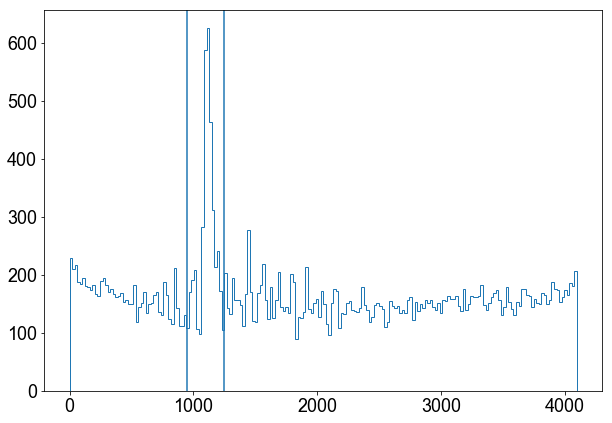

In [268]:
plt.hist(np.argmin(wfs, axis=1), histtype='step', bins=200)
plt.axvline(950)
plt.axvline(1250)

plt.show()

In [269]:
estimate_pois(wfs)

BG of 2285.5 expected, got 3856 counts
Fraction is 4.79 percent!


Here we define a temporary selection just to see where we should put the baseline bounds

In [270]:
good = (np.argmin(wfs, axis=1) > 1050) & (np.argmin(wfs, axis=1) < 1100) 

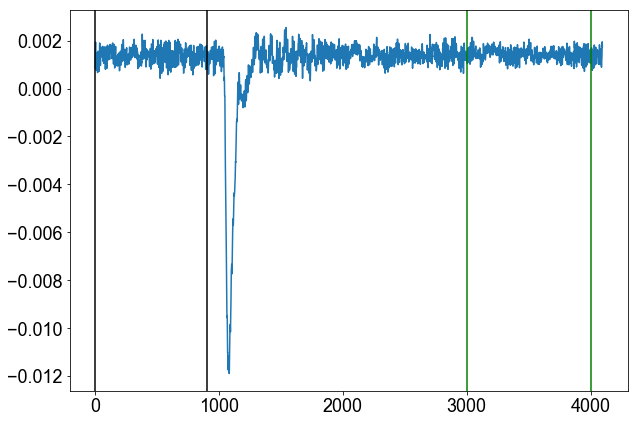

In [271]:
plt.plot(wfs[good][0])
for bounds, c in zip(baseline_bounds, ['black', 'green', 'red', 'orange']):
    for _l in bounds:
        plt.axvline(_l, color=c)
plt.show()

In [272]:
baselines, sigmas = get_baselines(wfs, baseline_bounds)

In [273]:
wfs = correct_baseline(wfs, baselines, baseline_bounds, method='interpolation', n = (0, 1))

In [274]:
wfs = invert_pulse(wfs)

Let us cut on the photons...

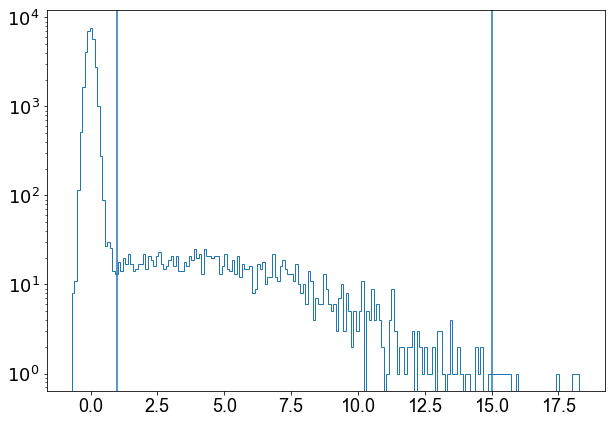

Found a gain of 4.879903 million.


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


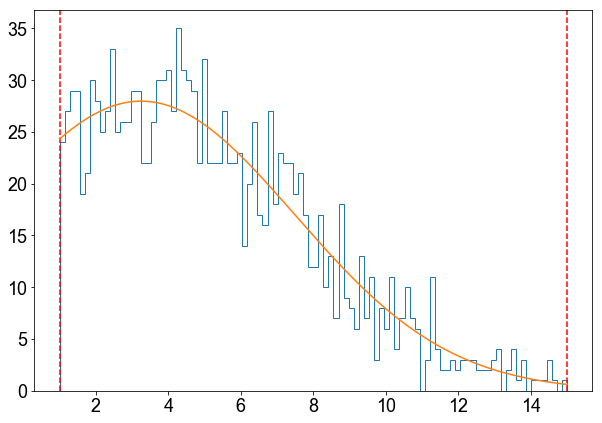

In [275]:
gain = get_gain(wfs, (1000, 1200), p0=[4,3], fit_range= [1, 15], delay_fit = False, plot=True, plot_guess = False,
         print_level = 0, stfu = True)

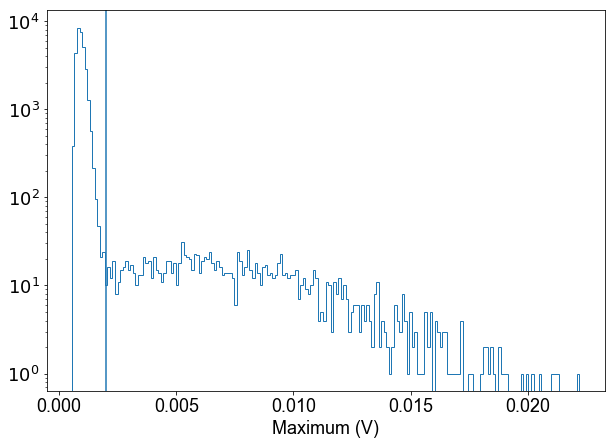

Passing 1563 of 32768 events (4.77 %)


In [276]:
wfs_sel = cut_height(wfs, [0.002, np.inf])

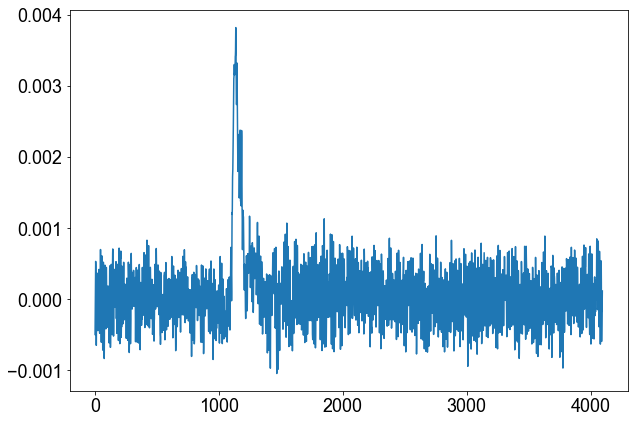

In [277]:
plt.plot(wfs_sel[2])

In [278]:
alignment_samples = find_alignment_sample(wfs_sel, (1000, 2000), 0.1)

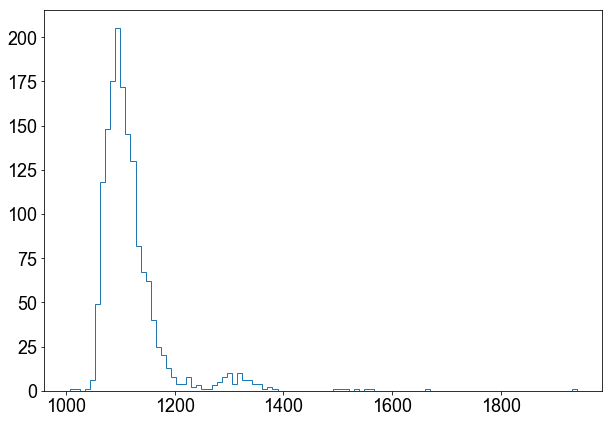

In [279]:
plt.hist(alignment_samples, bins=100, histtype='step')
plt.show()

In [280]:
what = wfs_sel[alignment_samples > 1250]

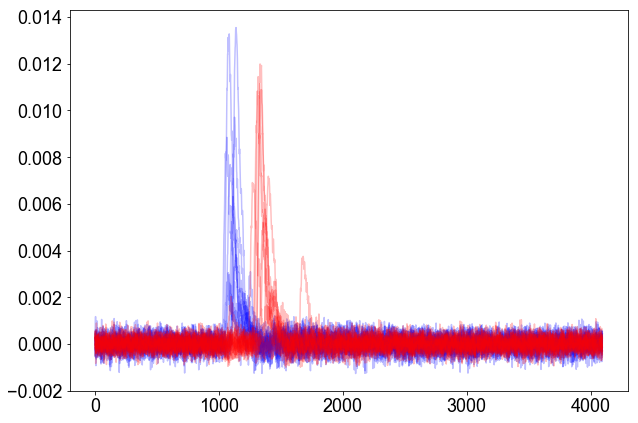

In [281]:
for i in range(10):
    plt.plot(wfs_sel[i], color='blue', alpha = 0.25)
for i in range(10):
    plt.plot(what[i], color='red', alpha = 0.25)

It looks like the late pulses are legit photons. Light travel time cannot explain the 20 ns delay. It is plobably the LED pulse itself. We can choose to either cut them or keep them.

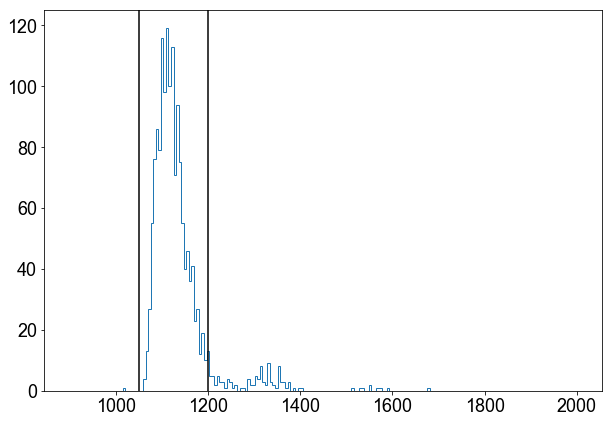

Cut 1444 of 1563 events (7.61 percent)


In [282]:
wfs_sel = cut_max_sample(wfs_sel, [1050, 1200])

In [283]:
alignment_samples = find_alignment_sample(wfs_sel, (1000, 1200), 0.1)

In [284]:
alignment_samples

array([1121, 1061, 1119, ..., 1138, 1107, 1088])

In [285]:
wfs_sel_al = align_wfs(wfs_sel, alignment_samples, extend_by=150)

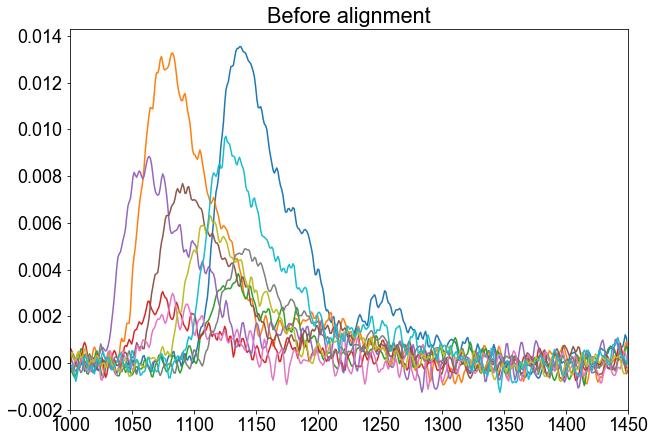

In [286]:
for i in range(10):
    plt.plot(wfs_sel[i])
plt.xlim(1000, 1450)
plt.title('Before alignment')

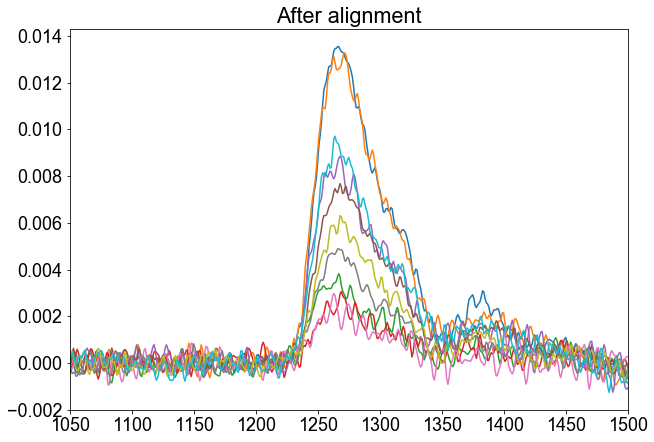

In [287]:
for i in range(10):
    plt.plot(wfs_sel_al[i])
plt.xlim(1050, 1500)
plt.title('After alignment')

In [288]:
def normalize(wfs, bounds):
    return wfs / np.sum(wfs[:, bounds[0]: bounds[1]], axis=1)[:,None]

In [289]:
ding =  normalize(wfs_sel_al, (1150, 1500))

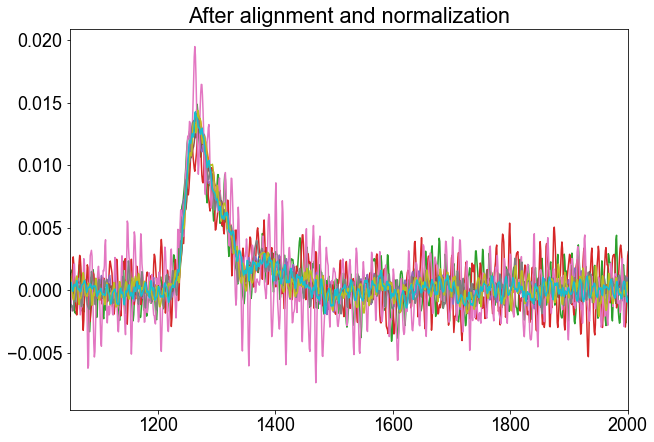

In [290]:
for i in range(10):
    plt.plot(ding[i])
plt.xlim(1050, 2000)
plt.title('After alignment and normalization')

In [291]:
def average_wf(wfs):
    return np.average(wfs, axis=0)

In [292]:
dt = 0.1 # ns
nsamples = 4096 + 2 * 150
t = np.arange(0, nsamples * dt, dt) - 1200 * dt

(-10, 200)

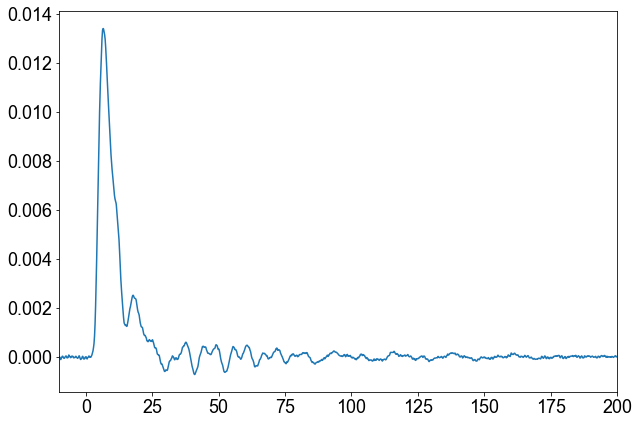

In [293]:
plt.plot(t, average_wf(ding))
plt.xlim(-10, 200)

(-10, 100)

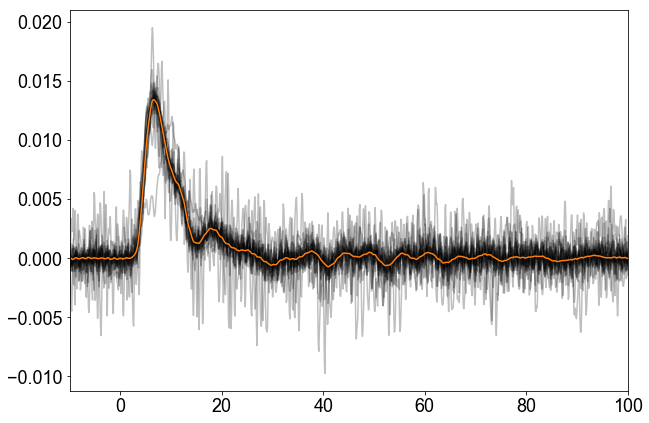

In [294]:
plt.plot(t, average_wf(ding))

for wf in ding[:20]:
    plt.plot(t, wf, color='black', alpha=0.25)
plt.plot(t, average_wf(ding))

plt.xlim(-10, 100)

In [295]:
wfs_f = filter_wfs(ding)

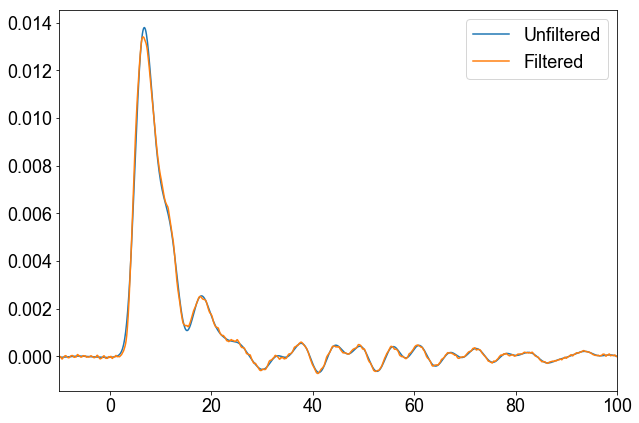

In [300]:
plt.plot(t, average_wf(wfs_f), label='Filtered')
plt.plot(t, average_wf(ding), label='')
plt.xlim(-10, 100)
plt.legend()

In [ ]:
wf = 